In [2]:
import pandas as pd

df = pd.read_csv('breast_cancer.csv')
target_variable ='target'
X = df.drop(target_variable, axis=1)




In [3]:
y = df['target']

In [4]:
X = X.values
y = y.values


In [5]:
import pandas as pd
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


# ----------------------
# Initialization
# ----------------------
def initialize_population(pop_size, num_features, fixed_population=None):
    if fixed_population is not None:
        return fixed_population.copy()  # use the fixed population

    population = np.random.randint(0, 2, (pop_size, num_features))

    # ensure each chromosome has at least one feature
    for i in range(pop_size):
        if np.sum(population[i]) == 0:
            rand_pos = np.random.randint(0, num_features)
            population[i][rand_pos] = 1

    return population

# ----------------------
# Fitness Function
# ----------------------
def fitness_function(individual, X, y, alpha=0.6, beta=0.1, gamma=0.3):

    if np.sum(individual) == 0:
        return 0

    selected_idx = np.where(individual == 1)[0]
    X_sub = X[:, selected_idx]

    model = DecisionTreeClassifier()

    accuracy = cross_val_score(model, X_sub, y, cv=5).mean()
    recall = cross_val_score(model, X_sub, y, cv=5, scoring="recall").mean()

    feature_ratio = len(selected_idx) / X.shape[1]

    fitness = (alpha * accuracy) - (beta * feature_ratio) + (gamma * recall)

    return fitness


In [6]:
def test_population_quality(X, y, pop_sizes, num_features):
    results = {}

    for pop in pop_sizes:
        # IMPORTANT: use your own initializer
        population = initialize_population(pop, num_features)

        fitness_values = []

        for chromosome in population:
            fitness_values.append(fitness_function(chromosome, X, y))

        fitness_values = np.array(fitness_values)

        results[pop] = {
            "mean_fitness": np.mean(fitness_values),
            "best_fitness": np.max(fitness_values),
            "fitness_variance": np.var(fitness_values),
        }

    return results



# example usage
population_sizes = [10, 20, 30, 40, 50]
num_features = X.shape[1]

pop_test_results = test_population_quality(X, y, population_sizes, num_features)

for pop, metrics in pop_test_results.items():
    print(f"\nPopulation Size = {pop}")
    print("Mean fitness    :", metrics["mean_fitness"])
    print("Best fitness    :", metrics["best_fitness"])
    print("Variance        :", metrics["fitness_variance"])



Population Size = 10
Mean fitness    : 0.7880363128155674
Best fitness    : 0.8191139126327597
Variance        : 0.00027048445890450704

Population Size = 20
Mean fitness    : 0.7882682534424058
Best fitness    : 0.8056804559697887
Variance        : 0.00013077935800775875

Population Size = 30
Mean fitness    : 0.7931627559436211
Best fitness    : 0.8184232283938063
Variance        : 0.00015353403049426872

Population Size = 40
Mean fitness    : 0.7858836494748649
Best fitness    : 0.8082958260352364
Variance        : 0.0001313837803869595

Population Size = 50
Mean fitness    : 0.7878095041448817
Best fitness    : 0.8173515944291739
Variance        : 0.00013431880127965078


In [7]:
def tournament_selection(fitness_values, num_parents, tournament_size=3):
    """
    Tournament selection: pick 'tournament_size' individuals,
    keep the one with highest fitness. Repeat to get num_parents.
    """
    n = len(fitness_values)
    selected = []

    for _ in range(num_parents):
        competitors = random.sample(range(n), tournament_size)
        best = max(competitors, key=lambda idx: fitness_values[idx])
        selected.append(best)

    return selected


In [8]:
def roulette_wheel_selection(fitness_values, num_parents):
    """
    Select parents using roulette-wheel selection.
    Returns indices of selected individuals.
    """
    fitness = np.array(fitness_values, dtype=float)

    total_fitness = np.sum(fitness)
    if total_fitness == 0:
        return random.sample(range(len(fitness)), num_parents)

    probabilities = fitness / total_fitness
    cum_prob = np.cumsum(probabilities)

    parents = []
    for _ in range(num_parents):
        r = random.random()
        for idx, cp in enumerate(cum_prob):
            if r <= cp:
                parents.append(idx)
                break

    return parents



In [9]:
def rank_based_selection(fitness_values, num_parents):
    """
    Select parents using rank-based probability selection.
    Returns indices of selected individuals.
    """
    # Sort fitness descending
    sorted_fitness = sorted(fitness_values, reverse=True)

    # Assign ranks and probabilities
    indv_rank_fit = {}
    for idx, fit in enumerate(fitness_values):
        rank = sorted_fitness.index(fit) + 1  # rank starts from 1
        indv_rank_fit[idx] = [rank]

    D_sum = sum(1 / info[0] for info in indv_rank_fit.values())

    for idx, info in indv_rank_fit.items():
        prob = 1 / (D_sum * info[0])
        info.append(prob)

    # Select num_parents individuals
    selected = []
    for _ in range(num_parents):
        rdm = random.random()
        sumProb = 0
        for idx, info in indv_rank_fit.items():
            sumProb += info[1]
            if sumProb > rdm:
                selected.append(idx)
                break

    return selected

In [10]:
def selection(fitness_values, method="tournament", num_parents=None, tournament_size=3):
    if num_parents is None:
        num_parents = len(fitness_values)  # default: select the whole population

    if method == "tournament":
        return tournament_selection(fitness_values, num_parents=num_parents, tournament_size=tournament_size)
    elif method == "roulette":
        return roulette_wheel_selection(fitness_values, num_parents=num_parents)
    elif method == "rank":
        return rank_based_selection(fitness_values, num_parents=num_parents)
    else:
        raise ValueError("Unknown selection method")



In [11]:
# 1) Single Point Crossover
def single_point_crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2


# 2) Two Point Crossover
def two_point_crossover(p1, p2):
    p1_idx, p2_idx = sorted(random.sample(range(1, len(p1)-1), 2))
    c1 = np.concatenate([p1[:p1_idx], p2[p1_idx:p2_idx], p1[p2_idx:]])
    c2 = np.concatenate([p2[:p1_idx], p1[p1_idx:p2_idx], p2[p2_idx:]])
    return c1, c2


# 3) Uniform Crossover
def uniform_crossover(p1, p2, p_swap=0.5):
    mask = np.random.rand(len(p1)) < p_swap
    c1 = np.where(mask, p1, p2)
    c2 = np.where(mask, p2, p1)
    return c1, c2


In [12]:
# ----------------------
# Mutation
# ----------------------
def mutate(pop, mutation_pop_rate, mutation_chromo_rate):
    pop = pop.copy()

    for i in range(len(pop)):
        if np.random.rand() < mutation_pop_rate:

            for j in range(len(pop[i])):
                if np.random.rand() < mutation_chromo_rate:
                    pop[i][j] = 1 - pop[i][j]

            # ensure at least 1 bit = 1
            if np.sum(pop[i]) == 0:
                pos = np.random.randint(0, len(pop[i]))
                pop[i][pos] = 1

    return pop


In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


def genetic_algorithm(
        X, y,
        pop_size=10,
        generations=30,
        selection_method="tournament",
        crossover_method="uniform",
        mutation_pop_rate=0.3,
        mutation_chromo_rate=0.05,
        fixed_population=None
    ):

    num_features = X.shape[1]
    population = initialize_population(pop_size, num_features, fixed_population=fixed_population)


    best_global_fitness = -1
    best_global_individual = None

    convergence_curve = []   # store best fitness per generation

    for gen in range(generations):

        fitness_values = [fitness_function(ind, X, y) for ind in population]

        best_idx = np.argmax(fitness_values)
        best_fit = fitness_values[best_idx]

        # track global best
        if best_fit > best_global_fitness:
            best_global_fitness = best_fit
            best_global_individual = population[best_idx].copy()

        convergence_curve.append(best_fit)

        print(f"Generation {gen+1}/{generations} | Best Fitness: {best_fit:.4f}")

        # selection
        parent_indices = selection(fitness_values, method=selection_method, num_parents=pop_size)
        parents = population[parent_indices]

        # ensure even number
        if len(parents) % 2 != 0:
            parents = np.vstack([parents, parents[random.randint(0, len(parents)-1)]])


        children = []

        # apply crossover
        for i in range(0, len(parents), 2):
            p1 = parents[i]
            p2 = parents[i+1]

            if crossover_method == "single":
                c1, c2 = single_point_crossover(p1, p2)
            elif crossover_method == "two":
                c1, c2 = two_point_crossover(p1, p2)
            else:
                c1, c2 = uniform_crossover(p1, p2)

            children.append(c1)
            children.append(c2)

        children = np.array(children)

        # mutation
        children = mutate(children, mutation_pop_rate, mutation_chromo_rate)

        # new population (elitism)
        new_population = [best_global_individual]

        while len(new_population) < pop_size:
            new_population.append(children[random.randint(0, len(children)-1)])

        population = np.array(new_population)

    return best_global_individual, best_global_fitness, convergence_curve



In [ ]:
"""#Run GA
best_ind, best_fit, curve = genetic_algorithm(X, y)

print("\nBest Fitness:", best_fit)
print("Selected Features Count:", np.sum(best_ind))
print("Mask:", best_ind)"""



In [ ]:
"""import numpy as np
selected_idx = np.where(best_ind == 1)[0]
X_selected = X[:, selected_idx]
print(f"Selected features indices: {selected_idx}")
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Recall: {rec:.4f}")

# Optional: plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()"""


In [14]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

def evaluate_solution(mask, X, y, test_size=0.3, random_state=42):
    selected_idx = np.where(mask == 1)[0]
    X_sub = X[:, selected_idx]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y, test_size=test_size, random_state=random_state
    )

    # Train model on training set
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average="macro")  # macro in case of multi-class
    cm = confusion_matrix(y_test, y_pred)

    return acc, rec, cm, selected_idx



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

def baseline_all_features(X, y, test_size=0.3, random_state=42):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train Decision Tree on all features
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)  # for binary target
    cm = confusion_matrix(y_test, y_pred)

    return acc, rec, cm


In [16]:
acc_base, rec_base, cm_base = baseline_all_features(X, y)

print("\n===== BASELINE (All Features) =====")
print("Accuracy:", acc_base)
print("Recall:", rec_base)
print("Confusion Matrix:\n", cm_base)


===== BASELINE (All Features) =====
Accuracy: 0.9415204678362573
Recall: 0.9351851851851852
Confusion Matrix:
 [[ 60   3]
 [  7 101]]


In [ ]:
def run_experiments(X, y):

    selection_methods = ["tournament", "roulette","rank"]
    crossover_methods = ["single", "two", "uniform"]
    mutation_pop_rates = [0.1, 0.3, 0.5]
    mutation_chromo_rates = [0.01, 0.05, 0.1]

    results = []
    pop_size = 20
    fixed_population = initialize_population(pop_size, X.shape[1])
    for sel in selection_methods:
        for cross in crossover_methods:
            for mpr in mutation_pop_rates:
                for mcr in mutation_chromo_rates:

                    print(f"\n Running GA | Sel={sel} | Cross={cross} | MP={mpr} | MC={mcr}")

                    best_ind, best_fit ,curve = genetic_algorithm(
                        X, y,
                        pop_size,
                        generations=30,
                        selection_method=sel,
                        crossover_method=cross,
                        mutation_pop_rate=mpr,
                        mutation_chromo_rate=mcr,
                        fixed_population=fixed_population
                    )

                    acc, rec, cm, selected_idx = evaluate_solution(best_ind, X, y)

                    results.append({
                        "Selection": sel,
                        "Crossover": cross,
                        "MutationPopRate": mpr,
                        "MutationChromRate": mcr,
                        "Fitness": best_fit,
                        "Accuracy": acc,
                        "Recall": rec,
                        "NumFeatures": len(selected_idx),
                        "Features": selected_idx,
                        "Curve": curve
                    })

    return results


In [ ]:
results = run_experiments(X, y)



 Running GA | Sel=tournament | Cross=single | MP=0.1 | MC=0.01
Generation 1/30 | Best Fitness: 0.8080
Generation 2/30 | Best Fitness: 0.8139
Generation 3/30 | Best Fitness: 0.8137
Generation 4/30 | Best Fitness: 0.8311
Generation 5/30 | Best Fitness: 0.8261
Generation 6/30 | Best Fitness: 0.8227
Generation 7/30 | Best Fitness: 0.8258
Generation 8/30 | Best Fitness: 0.8277
Generation 9/30 | Best Fitness: 0.8355
Generation 10/30 | Best Fitness: 0.8398
Generation 11/30 | Best Fitness: 0.8389
Generation 12/30 | Best Fitness: 0.8413
Generation 13/30 | Best Fitness: 0.8446
Generation 14/30 | Best Fitness: 0.8415
Generation 15/30 | Best Fitness: 0.8406
Generation 16/30 | Best Fitness: 0.8402
Generation 17/30 | Best Fitness: 0.8412
Generation 18/30 | Best Fitness: 0.8400
Generation 19/30 | Best Fitness: 0.8427
Generation 20/30 | Best Fitness: 0.8421
Generation 21/30 | Best Fitness: 0.8421
Generation 22/30 | Best Fitness: 0.8404
Generation 23/30 | Best Fitness: 0.8404
Generation 24/30 | Best F

=== Best Overall GA Run by Fitness ===
Selection Method: tournament
Crossover Method: single
Mutation Pop Rate: 0.1
Mutation Chrom Rate: 0.05
Best Fitness: 0.843212157590786
Accuracy: 0.9824561403508771
Recall: 0.9828042328042328
Number of Selected Features: 7
Reduction %: 76.66666666666666
Selected Feature Indices: [ 1  3  9 15 18 24 26]

Selected Feature Names:
- mean texture
- mean area
- mean fractal dimension
- compactness error
- symmetry error
- worst smoothness
- worst concavity


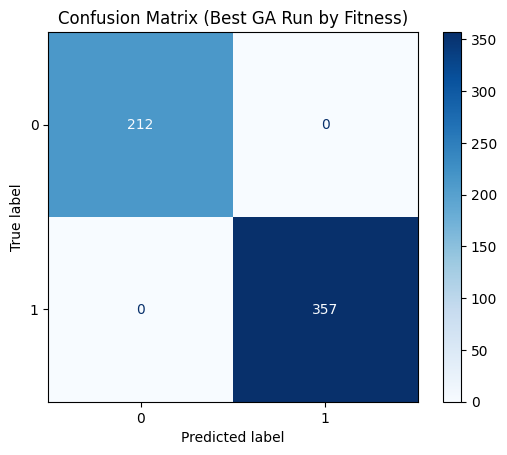

In [ ]:
print("=== Best Overall GA Run by Fitness ===")
print("Selection Method:", best_result['Selection'])
print("Crossover Method:", best_result['Crossover'])
print("Mutation Pop Rate:", best_result['MutationPopRate'])
print("Mutation Chrom Rate:", best_result['MutationChromRate'])
print("Best Fitness:", best_result['Fitness'])
print("Accuracy:", best_result['Accuracy'])
print("Recall:", best_result['Recall'])

num_selected = best_result['NumFeatures']
total_features = X.shape[1]

print("Number of Selected Features:", num_selected)
print("Reduction %:", (1 - num_selected / total_features) * 100)

print("Selected Feature Indices:", best_result['Features'])

# Get feature names
selected_features = df.drop("target", axis=1).columns[best_result['Features']]

print("\nSelected Feature Names:")
for f in selected_features:
    print("-", f)

# -----------------------------
# Train and evaluate on selected features
# -----------------------------
X_selected  = X[:, best_result['Features']]

model = DecisionTreeClassifier(random_state=42)
model.fit(X_selected, y)
y_pred = model.predict(X_selected)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Best GA Run by Fitness)")
plt.show()

=== Best Overall GA Run by Test Accuracy ===
Selection Method: tournament
Crossover Method: single
Mutation Pop Rate: 0.1
Mutation Chrom Rate: 0.05
Best Fitness: 0.843212157590786
Accuracy: 0.9824561403508771
Recall: 0.9828042328042328
Number of Selected Features: 7
Reduction %: 76.66666666666666
Selected Feature Indices: [ 1  3  9 15 18 24 26]

Selected Feature Names:
- mean texture
- mean area
- mean fractal dimension
- compactness error
- symmetry error
- worst smoothness
- worst concavity


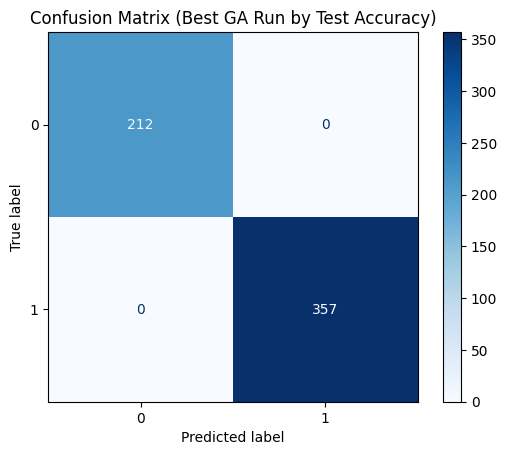

In [ ]:
# After all experiments finish
best_acc = 0
best_result = None

for r in results:
    if r['Accuracy'] > best_acc:
        best_acc = r['Accuracy']
        best_result = r


print("=== Best Overall GA Run by Test Accuracy ===")
print("Selection Method:", best_result['Selection'])
print("Crossover Method:", best_result['Crossover'])
print("Mutation Pop Rate:", best_result['MutationPopRate'])
print("Mutation Chrom Rate:", best_result['MutationChromRate'])
print("Best Fitness:", best_result['Fitness'])
print("Accuracy:", best_result['Accuracy'])
print("Recall:", best_result['Recall'])

num_selected = best_result['NumFeatures']
total_features = X.shape[1]

print("Number of Selected Features:", num_selected)
print("Reduction %:", (1 - num_selected / total_features) * 100)

print("Selected Feature Indices:", best_result['Features'])


selected_features = df.drop("target", axis=1).columns[best_result['Features']]

print("\nSelected Feature Names:")
for f in selected_features:
    print("-", f)


X_selected  = X[:, best_result['Features']]


model = DecisionTreeClassifier(random_state=42)
model.fit(X_selected, y)

y_pred = model.predict(X_selected)

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Best GA Run by Test Accuracy)")
plt.show()

In [ ]:
total_features = X.shape[1]

# Add Reduction % to each result AFTER all experiments finish
for r in results:
    selected = r["NumFeatures"]
    r["Reduction%"] = (1 - selected / total_features) * 100

# Print each result
for r in results:
    print(f"Selection: {r['Selection']}, Crossover: {r['Crossover']}, "
          f"Fitness: {r['Fitness']:.4f}, Accuracy: {r['Accuracy']:.4f}, "
          f"Reduction %: {r['Reduction%']:.2f}")

Selection: tournament, Crossover: single, Fitness: 0.8446, Accuracy: 0.9357, Reduction %: 76.67
Selection: tournament, Crossover: single, Fitness: 0.8432, Accuracy: 0.9825, Reduction %: 76.67
Selection: tournament, Crossover: single, Fitness: 0.8321, Accuracy: 0.9415, Reduction %: 66.67
Selection: tournament, Crossover: single, Fitness: 0.8359, Accuracy: 0.9474, Reduction %: 66.67
Selection: tournament, Crossover: single, Fitness: 0.8477, Accuracy: 0.9240, Reduction %: 83.33
Selection: tournament, Crossover: single, Fitness: 0.8390, Accuracy: 0.9298, Reduction %: 76.67
Selection: tournament, Crossover: single, Fitness: 0.8469, Accuracy: 0.9474, Reduction %: 76.67
Selection: tournament, Crossover: single, Fitness: 0.8455, Accuracy: 0.9298, Reduction %: 86.67
Selection: tournament, Crossover: single, Fitness: 0.8468, Accuracy: 0.9532, Reduction %: 76.67
Selection: tournament, Crossover: two, Fitness: 0.8444, Accuracy: 0.9240, Reduction %: 76.67
Selection: tournament, Crossover: two, Fitn

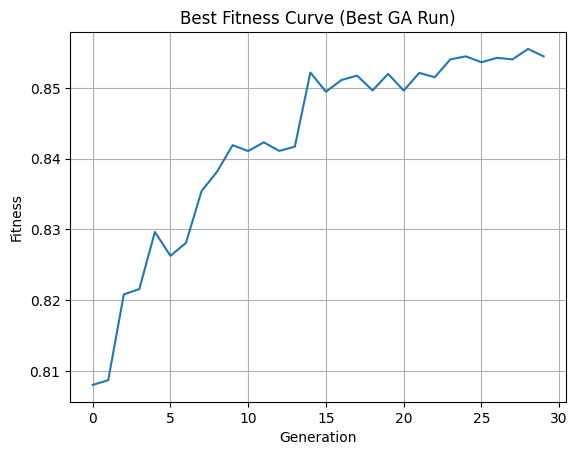

In [ ]:

best_result = max(results, key=lambda x: x['Fitness'])

plt.plot(best_result['Curve'])
plt.title("Best Fitness Curve (Best GA Run)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,20))

for res in results:
    plt.plot(res['Curve'], label=f"{res['Selection']} | {res['Crossover']} | Fitness: {res['Fitness']:.3f}")

plt.title("GA Convergence Curves")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.grid(True)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

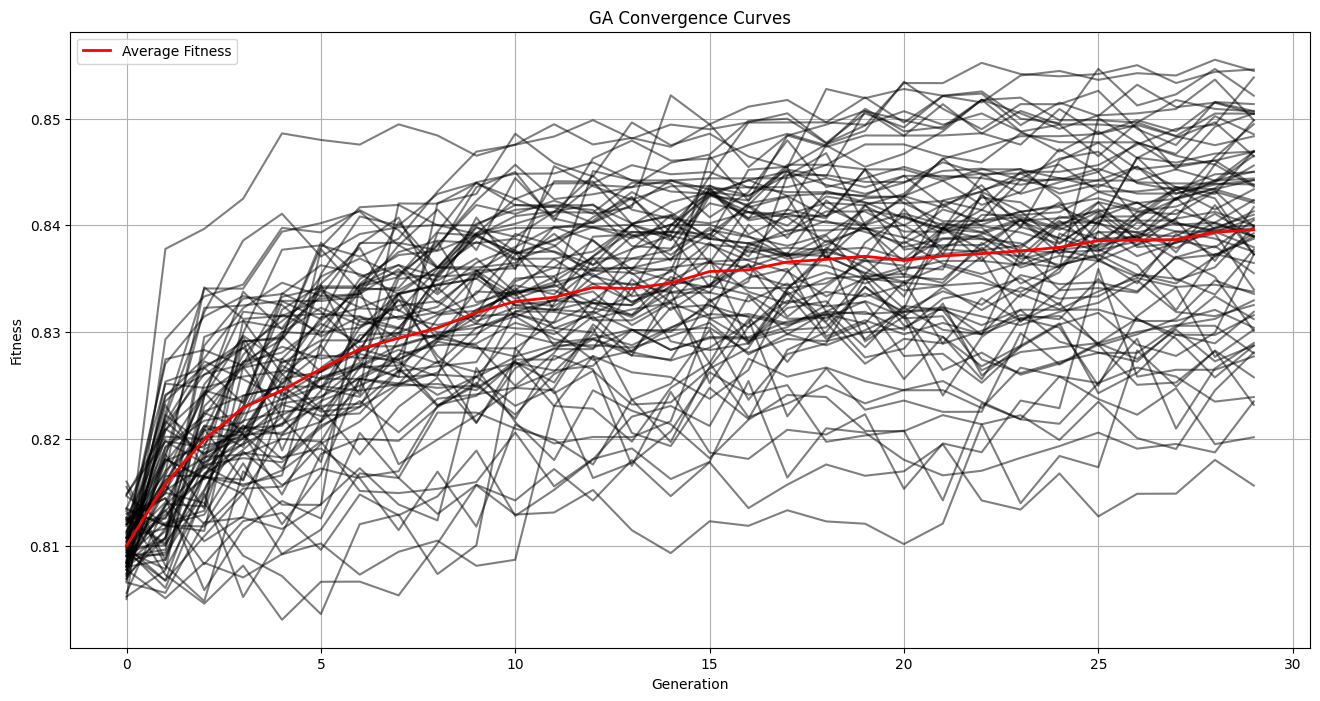

In [ ]:
plt.figure(figsize=(16,8))

all_curves = [res['Curve'] for res in results]
max_len = max(len(c) for c in all_curves)
padded_curves = [c + [c[-1]]*(max_len - len(c)) for c in all_curves]
average_curve = np.mean(padded_curves, axis=0)

# Plot individual experiment curves
for res in results:
    plt.plot(res['Curve'], color='black', alpha=0.5)

# Plot average curve
plt.plot(average_curve, color='red', linewidth=2, label='Average Fitness')

plt.title("GA Convergence Curves")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_results = pd.DataFrame(results)
average_metrics = df_results[["Fitness", "Accuracy", "Recall", "NumFeatures"]].mean()
print("\nAverage metrics over all experiments:")
print(average_metrics)


Average metrics over all experiments:
Fitness        0.841882
Accuracy       0.939932
Recall         0.941832
NumFeatures    7.283951
dtype: float64


 why do we select the best global individual every time?


      We select (and keep) the best global individual every generation because of elitism. The reason is simple:

      Preserve the best solution found so far – Without this, crossover or mutation could accidentally destroy the best feature subset you’ve discovered.

      Guarantee improvement or stability – GA is stochastic (random). By keeping the elite, you ensure the next generation is at least as good as the previous best, preventing regression.

      Speeds up convergence – The GA can focus on improving other individuals while always retaining the current best, so it converges faster to an optimal or near-optimal solution.

      💡 Analogy: It’s like keeping your best-performing player on a team while training new recruits — you don’t risk losing the MVP while trying new strategies.